In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-stock-price-data/AAPL.csv
/kaggle/input/ship-performance-clustering-dataset/Ship_Performance_Dataset.csv


In the maritime industry, ship performance analysis plays a critical role in reducing operational costs, improving efficiency, and enhancing decision-making. The challenge is to better understand the factors affecting ship performance, such as engine type, maintenance status, and external conditions like weather. Ships frequently navigate diverse routes under varying conditions, and optimizing the operational strategies based on these factors can help maximize profitability while ensuring sustainability.

Our model addresses the problem of clustering ships based on multiple performance attributes. By analyzing these attributes, such as speed, engine power, and cargo weight, the goal is to create meaningful groupings (clusters) of ships that exhibit similar operational profiles. These insights can guide fleet managers in making informed decisions about maintenance scheduling, route optimization, and performance benchmarking.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

# Load the dataset
df = pd.read_csv("/kaggle/input/ship-performance-clustering-dataset/Ship_Performance_Dataset.csv")

# Replace inf and -inf values with NaN
df.replace([float('inf'), float('-inf')], float('nan'), inplace=True)

# EDA
print(df.head())
print(df.isnull().sum())
print(df.info())
print(df.describe())

         Date       Ship_Type    Route_Type           Engine_Type  \
0  2023-06-04  Container Ship           NaN  Heavy Fuel Oil (HFO)   
1  2023-06-11    Fish Carrier    Short-haul         Steam Turbine   
2  2023-06-18  Container Ship     Long-haul                Diesel   
3  2023-06-25    Bulk Carrier  Transoceanic         Steam Turbine   
4  2023-07-02    Fish Carrier  Transoceanic                Diesel   

  Maintenance_Status  Speed_Over_Ground_knots  Engine_Power_kW  \
0           Critical                12.597558      2062.983982   
1               Good                10.387580      1796.057415   
2               Fair                20.749747      1648.556685   
3               Fair                21.055102       915.261795   
4               Fair                13.742777      1089.721803   

   Distance_Traveled_nm  Draft_meters Weather_Condition  Cargo_Weight_tons  \
0           1030.943616     14.132284          Moderate        1959.017882   
1           1060.486382     14.6


The objective of this project is to develop a machine learning (ML) model capable of clustering ships based on performance-related features. This allows fleet managers and analysts to gain insights into different ship groups that behave similarly. Additionally, the model will highlight the correlation between various operational features and guide future decisions. 2. Problem Formulation 2.1 Data Description

The dataset used for this project contains various features related to ship performance. The key features include:

Ship_Type: Type of ship (e.g., cargo, tanker).
Route_Type: Type of routes the ship takes (e.g., short-distance, long-distance).
Engine_Type: Type of engine on the ship.
Maintenance_Status: Status of the ship’s maintenance (e.g., on-schedule, delayed).
Speed_Over_Ground_knots: Speed at which the ship travels, measured in knots.
Engine_Power_kW: Power output of the ship's engine in kilowatts.
Cargo_Weight_tons: Weight of the cargo carried by the ship.
Operational_Cost_USD: The operational cost for each ship's voyage in USD.
Revenue_per_Voyage_USD: Revenue generated by the ship per voyage in USD.
Turnaround_Time_hours: The time taken for the ship to load, unload, and return to service.

There are a total of 2736 entries, with each entry representing one ship's operational data during a specific period.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

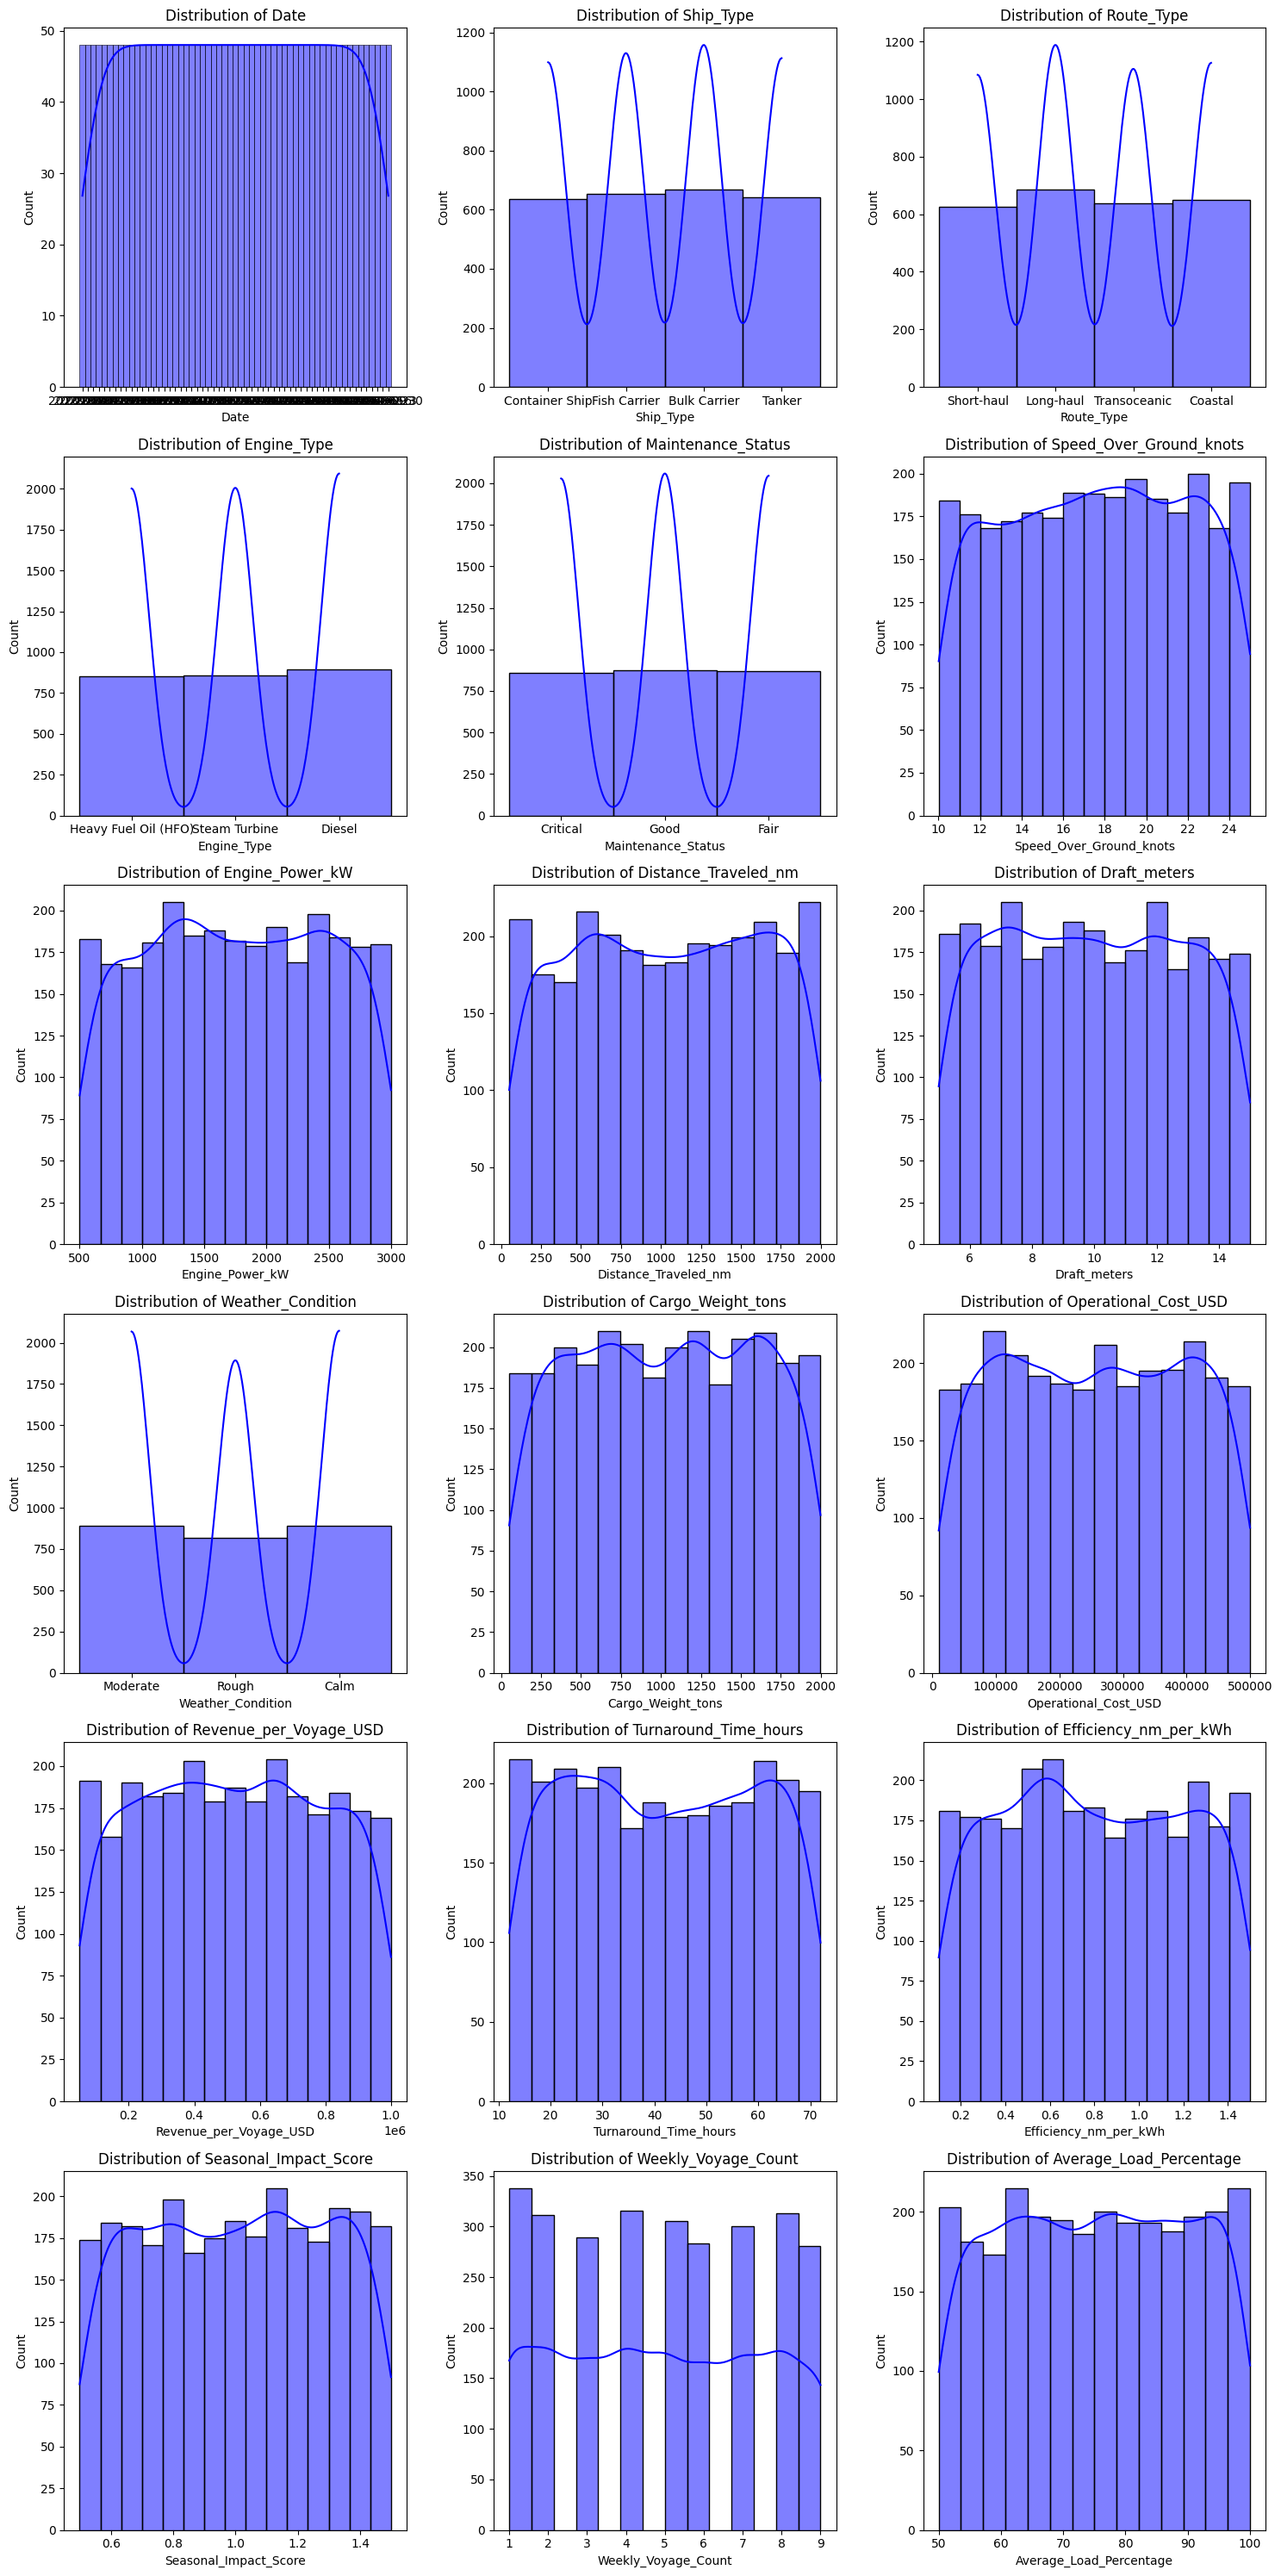

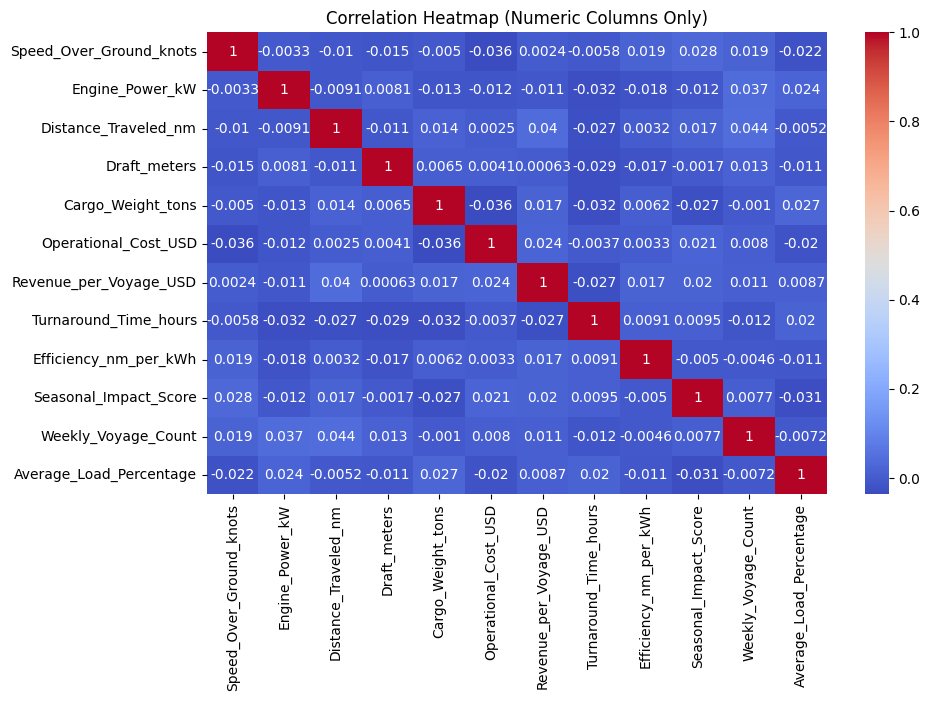

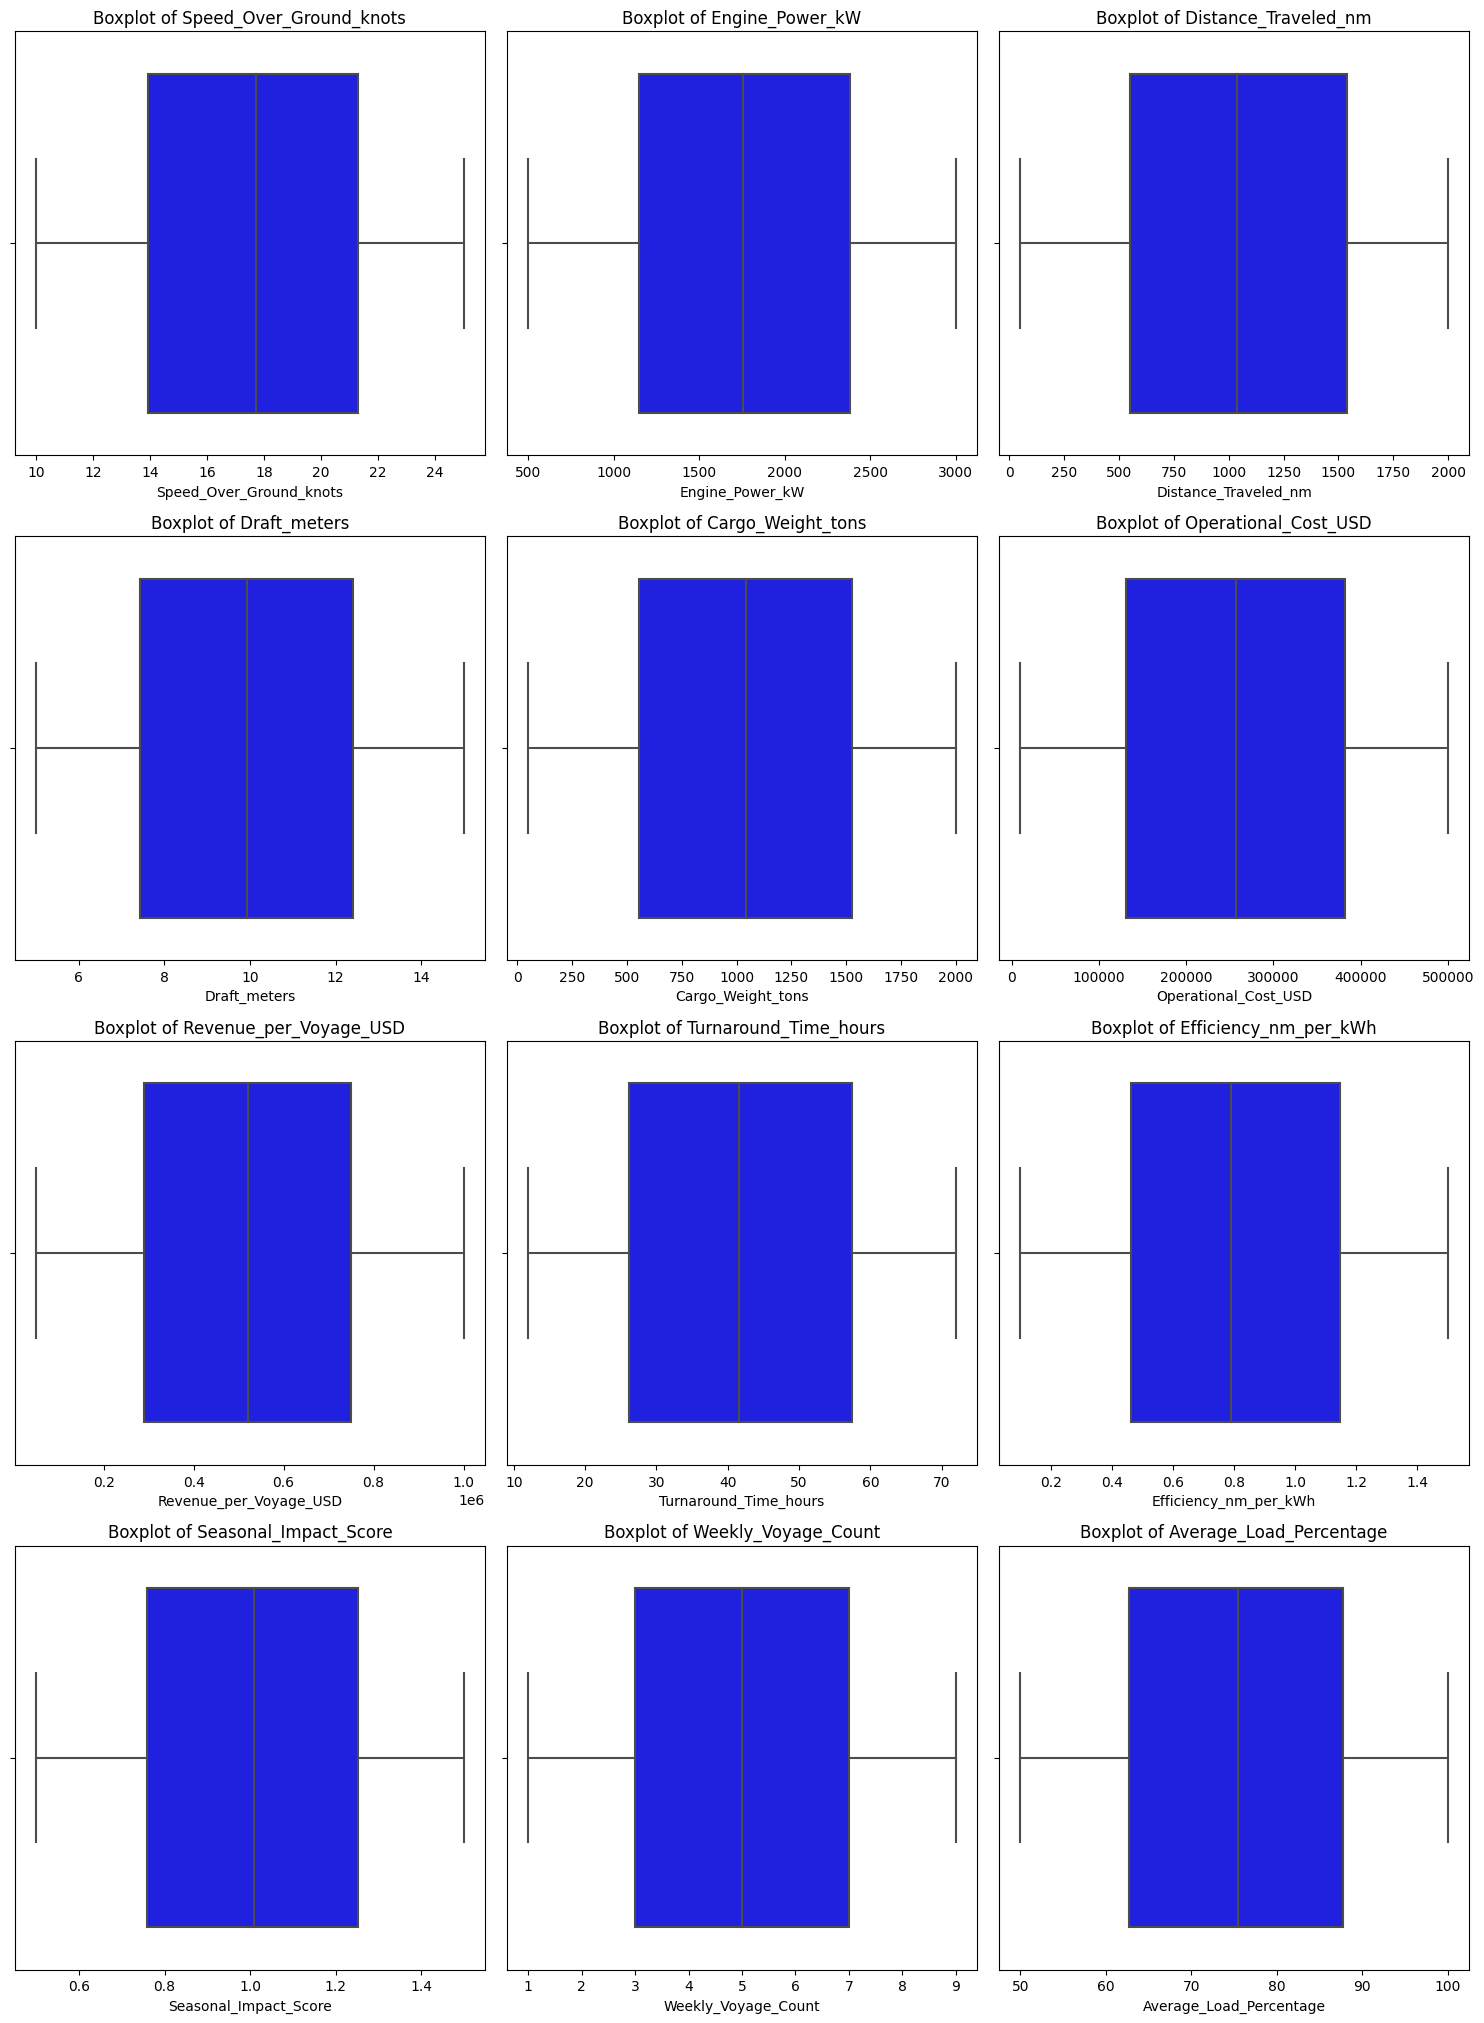

In [6]:

# Visualize feature distributions
n_cols = 3
n_rows = math.ceil(len(df.columns) / n_cols)

plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(df.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[column], kde=True, color='blue')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Select only numeric columns for the correlation heatmap
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Columns Only)")
plt.show()

# Data preprocessing
# Select only numeric columns for filling NaNs
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Fill NaN values with the mean of each numeric column
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Boxplots to visualize outliers
plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(numeric_columns, 1):  # Loop only through numeric columns
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[column], color='blue')
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# Outlier detection using Z-scores
z_scores = zscore(df[numeric_columns])
outliers = (abs(z_scores) > 3).all(axis=1)
df_no_outliers = df[~outliers]


To solve this problem using a KMeans clustering algorithm, a popular unsupervised machine learning method. Clustering is an unsupervised learning technique used to group similar data points based on their features without the need for labeled data.

KMeans is ideal for our problem because:

Unsupervised Learning: Since the dataset does not contain labels or target variables, unsupervised learning is appropriate.
Simplicity and Efficiency: KMeans is computationally efficient, making it suitable for large datasets like ours.
Interpretability: The results of KMeans are interpretable as we can examine the characteristics of each cluster to understand the types of ships it represents.

Preprocessing:
    Data Cleaning: Handle missing values by imputing the most frequent value for categorical columns and the mean for numerical columns.
    Feature Scaling: Standardize the numerical features to ensure they have a mean of 0 and a standard deviation of 1. This step is crucial because KMeans uses Euclidean distance to compute similarity between data points, and unscaled data can bias the results.

Choosing the Number of Clusters:
    We select the number of clusters using the Elbow Method. This technique involves plotting the sum of squared distances from each point to its assigned cluster center against different values of K and choosing the K at the "elbow" point where the rate of decrease in the sum of squared distances slows down.

Clustering:
    After determining the optimal number of clusters, we fit the KMeans model and assign each ship to a cluster.

Profile Creation:
    After clustering, we compute the mean values for each numerical feature within each cluster to create profiles that describe the typical characteristics of each group of ships.


In [ ]:

# Elbow Method for KMeans clustering
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Hyperparameter tuning (Silhouette score) for KMeans clustering
silhouette_scores = []
for k in range(2, 11):  # Test clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different k (Number of Clusters)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Best k based on silhouette score: {best_k}")


Before applying the KMeans model, I performed several preprocessing tasks:

Imputation of Missing Data: I filled missing categorical values with the mode and numerical values with the mean to avoid losing data.
Feature Scaling: I used StandardScaler from Scikit-learn to scale numerical features to the same scale for clustering.

Although unsupervised learning does not have ground truth labels to evaluate the model directly, I can evaluate the quality of clustering using Silhouette Score. This score measures how similar points are within the same cluster and how distinct a cluster is from others. A higher Silhouette score indicates better clustering.

After running KMeans clustering, I obtained clusters representing groups of ships with similar performance characteristics. The cluster profiles are calculated by averaging the numerical values of each feature within each cluster. Here are the key findings from the cluster profiles:

Cluster 1: Ships in this cluster have higher engine power, shorter turnaround times, and operate on high-revenue routes.
Cluster 2: Ships in this group have moderate operational costs and tend to carry larger amounts of cargo.
Cluster 3: Ships in this cluster have lower average speeds but are more energy-efficient, with a higher efficiency rating per kWh.

These profiles help to identify different groups of ships and their unique operational characteristics, assisting fleet managers in targeting improvements based on each cluster's needs.

The KMeans clustering model successfully grouped ships into clusters based on operational characteristics, allowing us to identify distinct groups of ships with similar performance profiles.
Each cluster reveals valuable insights into ship operations, such as efficiency, operational cost, and revenue generation.


In [ ]:

# Train KMeans with the best k
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
df['Cluster_BestKMeans'] = kmeans_best.fit_predict(X_scaled)

# Train DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

# Visualize the clusters from both KMeans and DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Cluster_BestKMeans'], y=df['Cluster_DBSCAN'], hue=df['Cluster_BestKMeans'], palette='viridis')
plt.title("Comparison of KMeans and DBSCAN Clusters")
plt.show()

# Cluster profiles (KMeans clustering with best k)
cluster_profiles = df.groupby('Cluster_BestKMeans').mean()
print(cluster_profiles)


KMeans Clustering – https://scikit-learn.org
Data Preprocessing and Feature Engineering – https://www.kaggle.com/learn